# Environment setup and imports

In [ ]:
!pip install evaluate #install eval library

In [ ]:
#importing libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
#hugging face
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          Trainer,TrainingArguments,pipeline)
from datasets import Dataset
import evaluate #for f1 and accuracy
#evaluation metrics
from sklearn.metrics import (accuracy_score,classification_report,confusion_matrix)

# Dataset loading and merging

In [ ]:
depression = pd.read_csv("/content/drive/MyDrive/depoct21.csv")
anxiety1 = pd.read_csv("/content/drive/MyDrive/anxinov21.csv")
anxiety2 = pd.read_csv("/content/drive/MyDrive/anxioct21.csv")
neutral = pd.read_csv("/content/drive/MyDrive/reddit_wsb.csv")

In [ ]:
#uploading and reading my uploaded csv from zip files
from google.colab import files
uploaded = files.upload()

Saving anxinov21.csv.zip to anxinov21.csv.zip
Saving anxioct21.csv.zip to anxioct21.csv.zip
Saving depoct21.csv.zip to depoct21.csv.zip
Saving reddit_wsb.csv.zip to reddit_wsb.csv.zip


In [ ]:
#load uploaded zip files and read the csv inside each zip
import io, zipfile
dataframes = {} #empty dictionary to store DataFrames
for zip_name, zip_bytes in uploaded.items():#sloop through each uploaded file
    z = zipfile.ZipFile(io.BytesIO(zip_bytes))
    csv_inside = z.namelist()[0]
    dataframes[zip_name] = pd.read_csv(z.open(csv_inside))#read the CSV into a pandas DataFrame
    print("Loaded:", zip_name, "->", csv_inside, "shape:", dataframes[zip_name].shape)


Loaded: anxinov21.csv.zip -> anxinov21.csv shape: (7391, 8)
Loaded: anxioct21.csv.zip -> anxioct21.csv shape: (7680, 8)
Loaded: depoct21.csv.zip -> depoct21.csv shape: (16116, 8)
Loaded: reddit_wsb.csv.zip -> reddit_wsb.csv shape: (53187, 8)


In [ ]:
depression = dataframes['depoct21.csv.zip']
anxiety1 = dataframes['anxinov21.csv.zip']
anxiety2 = dataframes['anxioct21.csv.zip']
neutral = dataframes['reddit_wsb.csv.zip']
# merge anxiety using pd.concat stacks rows on top of each other
anxiety = pd.concat([anxiety1, anxiety2], ignore_index=True) # ignore_index=True resets row numbering so they dont repeat


Anxiety combined dataset shape: (15071, 8)
Depression dataset shape: (16116, 8)


# Dataset cleaning and (minimal) preprocessing
including initial exploratory analysis

In [ ]:
print("Anxiety combined dataset shape:", anxiety.shape)
print("Depression dataset shape:", depression.shape)

In [ ]:
#add labels for training
depression["label"] = "depression"
anxiety["label"] = "anxiety"

In [ ]:
neutral.shape

(53187, 8)

In [ ]:
neutral.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [ ]:
#keeping only the column with the reddit post text
neutral= neutral[['body']]

In [ ]:
neutral = neutral.rename(columns={'body': 'selftext'}) #renaming so it matches the other ds

In [ ]:
neutral = neutral.dropna(subset=['selftext']) #remove rows where text is missing
neutral = neutral[neutral['selftext'].str.strip() != ""] #remove rows that are just empty strings or spaces

In [ ]:
#checking sizes of my datasets
print(depression.shape[0], anxiety.shape[0], neutral.shape[0])

16116 15071 24738


In [ ]:
#downsample neutral dataset to match the size of depression (about 13k) to maintain class balance
neutral_downsampled = neutral.sample(n=13350, random_state=42)
#randomly samples n rows, random_state ensures reproducibility

In [ ]:
neutral_downsampled.shape #confirming the size of downsampled dataset

(13350, 2)

In [ ]:
neutral_downsampled['label'] = 'neutral' #adding label to ds

In [ ]:
depression.head()

,Unnamed: 0,author,created_utc,score,selftext,subreddit,title,timestamp,label
0,0,AnotherBluePlatypus,1635684905,1,[removed],depression,What is enthusiasm?,2021-10-31 23:55:05,depression
1,1,paper_samosa97,1635684815,1,i am just too tired…my body has started to res...,depression,pov: it has been 5 years,2021-10-31 23:53:35,depression
2,2,Emotional_Pea2059,1635683923,1,[removed],depression,Trauma left me emotionless help,2021-10-31 23:38:43,depression
3,3,TheMournfulLady,1635683277,1,Warning: ranty rant\n\n\nI was just trying to ...,depression,I couldn’t tell a creepy stranger to f*ck off ...,2021-10-31 23:27:57,depression
4,4,tinydog360,1635683257,1,[removed],depression,Forever alone and single,2021-10-31 23:27:37,depression


In [ ]:
#count missing text
depression['selftext'].isna().sum()

np.int64(0)

In [ ]:
depression = depression[
    (depression['selftext'].notna()) & #keep only rows where text is not missing
    (depression['selftext'] != '[removed]') & #remove removed posts
    (depression['selftext'] != '[deleted]')] #remove deleted posts

In [ ]:
#keep only the text and label columns
depression = depression[['selftext', 'label']]

In [ ]:
#quick check
depression.head()

,selftext,label
1,i am just too tired…my body has started to res...,depression
3,Warning: ranty rant\n\n\nI was just trying to ...,depression
6,It's making me feel depressed and frustrated. ...,depression
8,I cry myself to sleep over a relationship that...,depression
9,I made my ex (39 F) feel like we ware just fri...,depression


In [ ]:
depression.shape #how many rows remain

(13332, 2)

In [ ]:
anxiety = anxiety[
    (anxiety['selftext'].notna()) & #where text is empty
    (anxiety['selftext'] != '[removed]') & #where text is removed
    (anxiety['selftext'] != '[deleted]')] #where text has been deleted

In [ ]:
anxiety.isna().sum() #how many mssig values r left

,0
Unnamed: 0,0
author,0
created_utc,0
score,0
selftext,0
subreddit,0
title,0
timestamp,0
label,0


In [ ]:
#keep only text n label columns
anxiety = anxiety[['selftext', 'label']]
anxiety.head() #confirm its just text

,selftext,label
0,"I'm not sure if it is anxiety or what, but lat...",anxiety
1,"Hi:)\n\nI’m not sure if this is anxiety, but I...",anxiety
2,I’m finishing my first semester at college in ...,anxiety
3,I’m just sitting in the airport now waiting fo...,anxiety
4,"I’m really freaking out. I don’t know why, but...",anxiety


In [ ]:
dataset = pd.concat([depression, anxiety, neutral_downsampled], ignore_index=True)
#combine all datasets into one

In [ ]:
#save dataset
dataset.to_csv('dataset.csv', index=False)

# Exploratory Data Analysis

In [ ]:
dataset.shape
#number of rows and the no of columns/ features

(40625, 2)

Interpretation = The dataset contains 40625 posts and 2 features, the post text (selftext) and the class label

In [ ]:
dataset['selftext'].isna().sum()
#check for any missing values

np.int64(0)


The dataset contains no more missing values

In [ ]:
dataset['label'].value_counts()
#check how many posts per class and whether one dominates the other, class imbalance

,count
label,
anxiety,13943
neutral,13350
depression,13332


In [ ]:
dataset['label'].value_counts(normalize=True)
#class imbalance in percentages distribution

,proportion
label,
anxiety,0.343212
neutral,0.328615
depression,0.328172


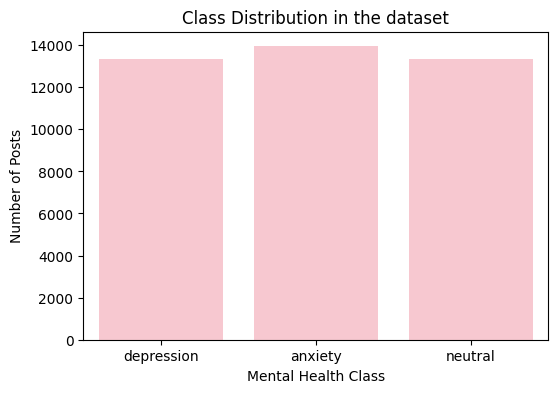

In [ ]:
plt.figure(figsize=(6,4)) #size of figure
sns.countplot(data=dataset, x='label', color='pink')
plt.title('Class Distribution in the dataset:')
plt.xlabel('Mental Health Class')
plt.ylabel('Number of Posts')
plt.show()
#visualisation of class imbalance so easier to see

Class distribution was examined to identify possible class imbalance.

The class distribution shows that the dataset is well balanced across the three mental health categories. Anxiety posts account for 34.3% of the data, while neutral and depression posts represent 32.9% and 32.8% respectively. The class counts are similar in magnitude, with anxiety having 13943 posts, neutral 13350, and depression 13332 posts.

This nearly uniform distribution reduces the risk of model bias toward any single class and ensures that performance isn't driven by class frequency. And as a result, standard evaluation metrics such as accuracy, precision, recall, and F1-score can be interpreted reliably without the need for additional class-weighting or rebalancing techniques etc.

In [ ]:
# post length analysis of characters
dataset['text_length'] = dataset['selftext'].str.len()
dataset['text_length'].describe() #average length etc

,text_length
count,40625.000000
mean,1004.383877
std,1674.342032
min,1.000000
25%,243.000000
50%,562.000000
75%,1131.000000
max,39722.000000


In [ ]:
dataset.groupby('label')['text_length'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
anxiety,13943.0,810.456860,855.504441,1.0,321.0,579.0,1004.0,19900.0
depression,13332.0,830.238899,947.625046,1.0,271.0,562.5,1055.0,21255.0
neutral,13350.0,1380.835206,2580.496359,1.0,131.0,525.0,1554.0,39722.0


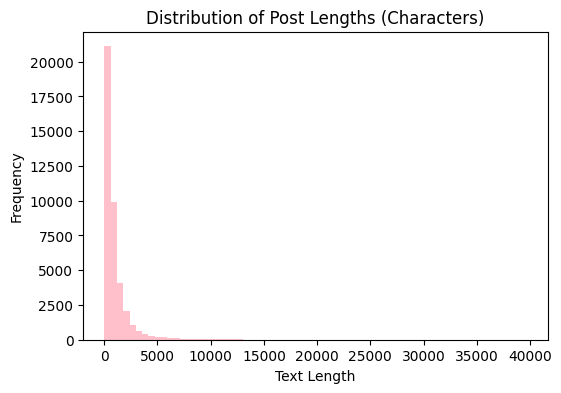

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(dataset['text_length'], bins=67,  color='pink') #bins represent range of character lengths and the height of each bar shows how many posts fall into that range
plt.title('Distribution of Post Lengths (Characters)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Initial exploratory data analysis was conducted to understand dataset structure, class distribution, and textual characteristics. The analysis confirmed balanced class labels and revealed variability in post length, highlighting the challenges of modelling informal social media text.

Posts labelled as anxiety and depression show very similar characteristics. Both classes have comparable mean post lengths (about 810-830 characters) and similar medians (about 560-580 characters), suggesting that users discussing anxiety and depression tend to write posts of similar length. This likely reflects comparable levels of emotional expression and  detail when discussing personal mental health experiences.

In contrast, neutral posts are on average significantly longer, with a mean length of 1,381 characters. The standard deviation for neutral posts is also substantially higher, which indicates a greater variability in post length. This suggests that neutral content includes longer explanations or contextual detail compared to mental health focused posts. The higher max value further supports this, showing that neutral posts can be much longer than anxiety or depression posts.



No other text cleaning will be applied because transformer models do this automatically to preserve context and word order.


In [ ]:
cleaned_dataset = pd.read_csv("/content/dataset.csv")

In [ ]:
!pip install transformers datasets evaluate accelerate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dataset.to_csv("/content/drive/MyDrive/cleaned_dataset.csv", index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# MODEL 1: DistilBERT

### Dataset preparation and mapping

*   Converted the pandas dataset to Hugging Face
dataset becuase HF doesnt train on pandas. This ensures compatability
*   Class labels were mapped to numerical values to allow the model to process them during training. I did this manually so it is transparant and consistent (removes any confusion)



In [ ]:
hf_dataset = Dataset.from_pandas(cleaned_dataset) #convert ds to hf ds format

Manual mapping:
Hugging Face, Sequence classification. Available at: https://huggingface.co/docs/transformers/en/tasks/sequence_classification

In [ ]:
label2id = {"anxiety": 0, "depression": 1, "neutral": 2} #maps string labels to ids for model training
id2label = {0: "anxiety",1: "depression",2: "neutral"} #reverse mapping

#eplaces the text labels in the dataset with id
hf_dataset = hf_dataset.map(lambda x: {"label": label2id[x["label"]]} )
#lambda automates process across entire ds so dont need a manual loop

Map:   0%|          | 0/40625 [00:00<?, ? examples/s]

Walkthrough on BERT model:
https://medium.com/@whyamit101/fine-tuning-bert-a-practical-guide-b5c94efb3d4d

### Tokeniser Initialisation


*   Loaded the pre trained DistilBERT tokenizer to convert the text into numerical tokens that are compatable with the model
*   Removes need for manual preprocessing
*   Process includes splitting text into tokens, breaks sentences into smaller units, mapping tokens to numerical IDs, adding special tokens such as CLS, and creating attention masks to distinguish true meaningful text from padding (fake text)

[CLS] Classification token added to the beginning of input sentences. it acts as a summary representation of the entire sentence by gathering infomation and context. The final [CLS] is used by the model to perform the classification task.

[SEP] Separator token thats added to the end of a sentence that tells the model where one sentence ends and another begins, so the model can understand structure and boundaries.





In [ ]:
distil_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased") #load tokenizer

### Tokenisation Function

*   Padding and truncation is used to ensure all inputs have a fixed length, which allows efficient batch processing as transformers require fixed sized inputs (and all my text is diff lengths)
*   Padding adds fake tokens (marked as 0) to shorter input text. There is a padding mask that tells the attention mechanism to ignore the fake padded tokens (0) and which are real (1)

Hugging Face, Padding and truncation. Available at: https://huggingface.co/docs/transformers/pad_truncation



The output is two new columns created: input_ids and attention_mask
*   input_id is where each word has a unique id that distilBERT is trained on
*   attention_mask tells the model which input tokens to pay attention to (1) and which ones are fake and to ignore them (0)




In [ ]:
def distil_tokenize_function(examples):
    return distil_tokenizer(examples["selftext"], #list of texts
        truncation=True, #cut long posts to models max allowed length limit
        padding= "max_length", #ensure a uniform input size
        max_length=256) #keeps memory manageable bc reddit posts r long

### Applying tokenisation to my dataset


*   Tokenisation is applied to the whole dataset
*   Using batched processing to improve efficiency instead of processing each input individually. hf internally chooses a safe efficient batch size.

Batching used in tokenisation is seperate from training batch size and doesnt affect model learning, just speeds up tokenisation.



In [ ]:
distil_tokenized_dataset = hf_dataset.map(distil_tokenize_function,batched=True,)
#tokenize the dataset

Map:   0%|          | 0/40625 [00:00<?, ? examples/s]

### Train test split

*   80/20 split
*   why we need unseen test data



In [ ]:
distil_split_dataset = distil_tokenized_dataset.train_test_split(
    test_size=0.2, #80 20 split, industry standard, enough data to evaluate and keeps train data large
    seed=42) #reproducbile, fixed randomness

distil_train_dataset = distil_split_dataset["train"] #model learns patterns
distil_test_dataset = distil_split_dataset["test"] #model evaluated on unseen data

### Model Initialisation
*   Loads the pre trained model and adapts it for my multi class classification task
*   A classification head is added on top of the encoder. This is a small neural network layer that maps the encoded representation to class scores.
*    The [CLS] token is passed to the classification head
*   The classification head outputs logits, which are raw, unnormalised scores representing the model’s confidence for each class.


Model finetuning and training were implemented using the Hugging face Transformers library, following the official documentation for training transformer models with the pytorch Trainer:

Hugging Face, Training with PyTorch Trainer. Available at: https://huggingface.co/docs/transformers/en/training#train-with-pytorch-trainer


In [ ]:
distil_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3, #configures the number of classes
    label2id=label2id,id2label=id2label) #used during prediction so outputs r named
print("DistilBERT model loaded successfully!!")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBERT model loaded successfully!


### Training arguments
*   Defining how the model learns
*   Epoch is a complete pass through the training dataset,  a balance is needed as multiple epochs allow the model to gradually improve, but too many epochs cause overfitting.
*   Learning rate determines how fast the model learnings by adjusting its weights. The small value of 2e-5 is a standard for transformers, because the model already knows the language and has pre trained knowledge
*   Batch size determines how many samples are processed at once
*   Weight decay is applied as a regularisation technique to reduce overfitting, by discouraging excessively large weights.

In [ ]:
distilbert_training_arguments= TrainingArguments( #object stores all settings that control how the model is trained and evaluated
    output_dir="./distilbert_results",# folder where model checkpoints weights outputs r saved
    eval_strategy="epoch", #evaluate model at the end of each epoch
    save_strategy="epoch", #save model aftr each epoch
    learning_rate=2e-5,   #standard small lr for transformers
    per_device_train_batch_size=8, #batch size of how many training samples r procressed at once per GPU, is small to avoid crashes and long time, stable learning
    per_device_eval_batch_size=8,   #batch size for evaluation, good balance between gpu memory usage and training speed
    num_train_epochs=2,  #only doing 2 epochs bc efficient + avoids overfitting
    weight_decay=0.01, #regularisation technique to reduce overfitting by making large weights smaller
    logging_dir="./logs", #where training logs r stored
    logging_steps=100)#logs metrics every 100 steps

### Model fine tuning


*   During fine-tuning, the model processes training data in mini-batches
*   For each batch, a forward pass is performed, producing logits for each class that are used to compute loss, by comparing the predictions to the true labels.
*   Loss is how incorrect the models predictions are and how confident these incorrect predictions were


*   Weights control how strongly words influence decisions. Forward pass takes the text, converts to numbers, feeds into the models and the model uses the current weights and outputs scores for each class.


*   Loss measures how different the models prediction is from the true label. If the prediction label is wrong, the loss is high. Loss shows how wrong and how confident the mistake was.

*   Back propogation propagates this error back though the network, and computes gradients, which indicate how each model weight contributed to the error.

*   The gradient represent the direction and magnitude by which each weight should be adjusted to reduce the loss.

*   The weights slightly adjust the models weight in the direction that minimises loss, this happens after every batch and every epoch. This will help the model gradually generalise (perform better on new unseen data)




In [ ]:
distil_trainer.train() #fine tunes distilbert on my dataset

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.268000,0.254191,0.909169,0.909315


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.268000,0.254191,0.909169,0.909315


### Model evaluation
*   The model predicts a label on test data, compares the predicted label and true label, metrics are calculated and performance is recorded


In [ ]:
distil_trainer.evaluate() #computes metrics on the test dataset

{'eval_loss': 0.28761330246925354,
 'eval_accuracy': 0.9147076923076923,
 'eval_f1': 0.9149507713088058,
 'eval_runtime': 62.4048,
 'eval_samples_per_second': 130.198,
 'eval_steps_per_second': 16.281,
 'epoch': 2.0}

### Saving DistilBERT model

In [ ]:
distil_save_path_drive = "/content/drive/MyDrive/distilbert_anxiety_depression_classifier"

# save model, weights and tokenizer
distil_trainer.save_model(distil_save_path_drive)
distil_tokenizer.save_pretrained(distil_save_path_drive)

('/content/drive/MyDrive/distilbert_anxiety_depression_classifier/tokenizer_config.json',
 '/content/drive/MyDrive/distilbert_anxiety_depression_classifier/special_tokens_map.json',
 '/content/drive/MyDrive/distilbert_anxiety_depression_classifier/vocab.txt',
 '/content/drive/MyDrive/distilbert_anxiety_depression_classifier/added_tokens.json',
 '/content/drive/MyDrive/distilbert_anxiety_depression_classifier/tokenizer.json')

In [ ]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

In [ ]:
#function to calculate metrics after each eval
def compute_metrics(eval_pred): #evaluation prediction passed in by trainer during eval contain models outputs and true labels
    logits, labels = eval_pred #logits r raw model outputs, labels r the true correct class labels from the ds
    predictions = logits.argmax(axis=-1) #argmax finds the index of the largest value in each row and converts raw score inton the predicted class labels
    #axis =-1  means “across the last dimension” (the class dimension)

    return {"accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
            "f1": f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"]}

#macro averaging which finds f1 for each class seperately then averages them equally, good for class imbalance

### Trainer initialisation


*   The Hugging Face Trainer is initialised to manage the training and evaluation workflow.
*   It links together the model, training arguments, training dataset, evaluation dataset, tokenizer and evaluation metrics
*   The Trainer automatically handles batching, metric computation, and evaluation scheduling




In [ ]:
#prepares model for training
distil_trainer = Trainer(
    model=distil_model,#the model im finetuning
    args=distilbert_training_arguments,#all the training rules and hyperparameters inc epochs, batch size, learning rate
    train_dataset=distil_train_dataset, #tokenized training data
    eval_dataset=distil_test_dataset, #the test ds used  as eval dataset to calculate validation metrics at the end of each epoch
    tokenizer=distil_tokenizer,  #tokenizer used for encoding text for padding etc
    compute_metrics=compute_metrics) #function to take model predictions and true labels and computer metrics , without this the trained would report only loss

/tmp/ipython-input-887717515.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  distil_trainer = Trainer(
